# Бусаров 1 лабораторная

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

%matplotlib inline

from util import load_mnist
from util import plot_embedding

### Базовый класс Layer

In [88]:
class Layer:

    def __init__(self):
        pass
    
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        input_dim = input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### ReLu Layer

In [89]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        output = np.maximum(input, 0)
        return output
    
    def backward(self, input, grad_output):
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask        

### Dense Layer

In [90]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        output = np.dot(input, self.weights) + self.biases
        return output

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Loss Function

In [91]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Final Neural Network

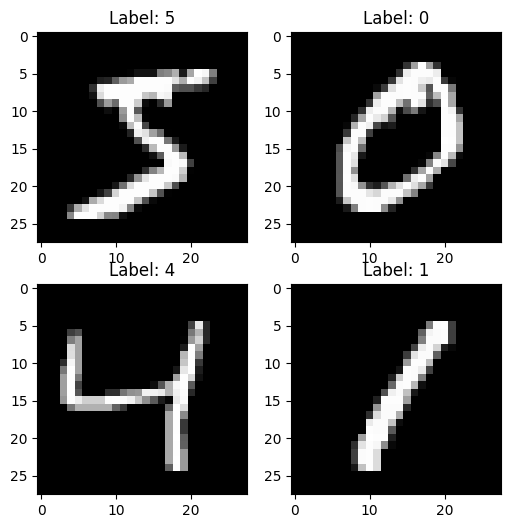

In [92]:
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [93]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

In [94]:
def forward(network, X):
    
    activations = []
    input = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
    
    assert len(activations) == len(network)
    
    return activations

In [95]:
def predict(network, X):
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [96]:
def train(network,X,y):
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations
    logits = layer_activations[-1]
    
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
        
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad)

    return np.mean(loss)

In [97]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [98]:
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.99012
Val accuracy: 0.9732


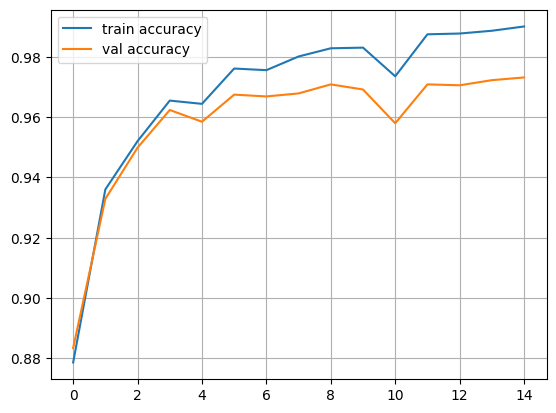

In [99]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [100]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

In [101]:
subset_ids = np.random.permutation(X_train.shape[0])[:1000]

x_original = X_train[subset_ids]
x_learnt = train_hidden_representations[subset_ids]

x_original_tsne = TSNE(n_components=2).fit_transform(x_original)
x_learnt_tsne = TSNE(n_components=2).fit_transform(x_learnt)

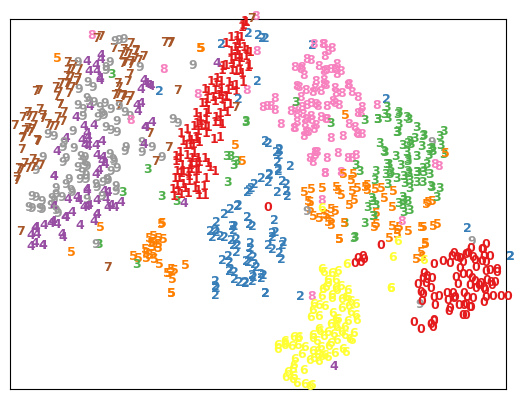

In [102]:
plot_embedding(x_original_tsne, y_train[subset_ids])

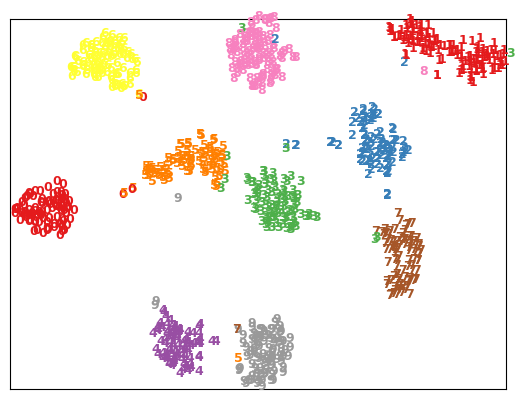

In [103]:
plot_embedding(x_learnt_tsne, y_train[subset_ids])

In [104]:
new_y_train = y_train % 2
new_y_test = y_test % 2

In [105]:
lr = LogisticRegression(solver="lbfgs")

train_repr = train_hidden_representations
test_repr = test_hidden_representations

lr.fit(train_repr, new_y_train)

accuracy = lr.score(test_repr, new_y_test)
print(f"Accuracy of parity prediction: {accuracy}")

Accuracy of parity prediction: 0.9501


/home/shabalka/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Контрольные Вопросы 

## Биологический и искусственный нейрон. Основные функции активации нейронов.

- Биологический нейрон: Это основной строительный блок нервной системы живых организмов. Он состоит из тела клетки, дендритов (получение сигналов), аксона (передача сигналов) и синапсов (места контакта с другими нейронами). Биологические нейроны обрабатывают и передают электрические и химические сигналы в организме.

- Искусственный нейрон: Это абстракция биологического нейрона, используемая в нейронных сетях. Он принимает входные данные, применяет к ним веса, выполняет операцию активации и передает результат следующему слою нейронов. Искусственные нейроны объединяются в слои для обработки сложных данных.

### Основные функции активации нейронов

- Передача сигнала: Нейроны принимают входные значения, умножают их на соответствующие веса, суммируют результаты и применяют функцию активации для определения, нужно ли активировать нейрон или нет.

- Введение нелинейности: Функции активации в нейронных сетях помогают моделировать нелинейные отношения между входными и выходными данными. Без нелинейности нейронная сеть была бы просто линейным преобразованием.



## Преимущества нейронных сетей

Нейронные сети обладают несколькими ключевыми преимуществами:
1. Обучение на данных: Нейронные сети могут обучаться на больших объемах данных, извлекая сложные закономерности и паттерны.
2. Способность к обобщению: Хорошо обученные нейронные сети способны обобщать свои знания на новые, ранее не виданные данные.
3. Автоматизация: Нейронные сети могут выполнять задачи автоматически, без необходимости явного программирования для каждого случая.

## Классификации нейронных сетей, области применения и решаемые задачи. Основные направления развития нейрокомпьютинга.

### Классификация нейронных сетей:
  - По структуре: Однослойные, многослойные, рекуррентные, сверточные и т. д.
  - По способу обучения: Обучение с учителем, без учителя, с подкреплением.
  - По архитектуре: CNN (Convolutional Neural Networks), RNN (Recurrent Neural Networks), GANs (Generative Adversarial Networks) и т. д.

### Области применения и решаемые задачи:
  - Обработка изображений: Распознавание образов, сегментация изображений.
  - Обработка естественного языка: Машинный перевод, анализ тональности текста.
  - Рекомендательные системы: Персонализированные рекомендации товаров или контента.
  - Медицина: Диагностика заболеваний, анализ медицинских изображений.
  - Финансы: Прогнозирование рынка, мошенническое обнаружение и т. д.

### Основные направления развития нейрокомпьютинга

1. Обучение с подкреплением: Усиление интереса к алгоритмам, способным обучаться на основе взаимодействия с окружающей средой и получению награды.
2. Обучение без учителя: Развитие методов, позволяющих обучаться на наборах данных, не размеченных на выходные классы или значения.
3. Объединение нейронных сетей с другими технологиями: Использование нейронных сетей с компьютерным зрением, робототехникой, умными гаджетами и другими технологиями.